In [164]:
import numpy as np
import pandas as pd

import lightgbm as lgb
import optuna
import pickle
import seaborn as sns
import catboost as cat

In [165]:
# Import my modules.
import sys, os
from pathlib import Path
current_dir = os.path.join(Path().resolve())
sys.path.append(str(current_dir) + '/../')

from modules import utils
from modules import models

In [1]:
import importlib
importlib.reload(models)

NameError: name 'models' is not defined

In [167]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 150)

In [168]:
# Parameters
USE_LAG = 5
USE_OLD_LOG = False
USE_TREND=False

## Import data and create basic features

In [169]:
BASE = '../input/'
date_col = 'first_day_of_month'
cat_cols = ['county', 'state']
mbd = 'microbusiness_density'
idx = 'row_id'

In [170]:
df_census = pd.read_csv(BASE + 'census_starter.csv', index_col='cfips')
df_train = pd.read_csv(BASE + 'train.csv',  index_col=idx)
df_test = pd.read_csv(BASE + 'test.csv',  index_col=idx)
df_subm = pd.read_csv(BASE + 'sample_submission.csv',  index_col=idx)

In [171]:
state_dict = df_train[['cfips', 'state', 'county']]
state_dict = state_dict.set_index('cfips')
state_dict = state_dict.drop_duplicates()
state_dict = state_dict.to_dict()

df_test['state'] = df_test['cfips'].map(state_dict['state'])
df_test['county'] = df_test['cfips'].map(state_dict['county'])

df_all = pd.concat([df_train, df_test], axis=0)

df_all[date_col] = pd.to_datetime(df_all[date_col])

df_all['year'] = df_all[date_col].dt.year
df_all['month'] = df_all[date_col].dt.month
df_all['scale'] = (df_all[date_col] - df_all[date_col].min()).dt.days
df_all['scale'] = df_all['scale'].factorize()[0]

df_all = df_all.drop(columns=[date_col])
df_all.sort_index(inplace=True)

df_all['county'] = (df_all['county'] + df_all['state']).factorize()[0]
df_all['state'] = df_all['state'].factorize()[0]

# df_all.to_csv('../output/df_all.csv')

## Create features for modeling

In [172]:
outliers = []
cnt = 0

for o in df_all.cfips.unique():
    indices = (df_all['cfips']==o)
    tmp = df_all.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    
    for i in range(37, 2, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
    var[0] = var[1]*0.99
    df_all.loc[indices, mbd] = var

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [173]:
for i in range(30, 39):
    dt = df_all.loc[df_all.scale==i].groupby('cfips')['active'].agg('last')
    df_all[f'select_lastactive{i}'] = df_all['cfips'].map(dt)

    dt = df_all.loc[df_all.scale==i].groupby('cfips')[mbd].agg('last')
    df_all[f'select_lastmbd{i}'] = df_all['cfips'].map(dt)

In [174]:
for i in range(1, 5):
    df_all[f'select_rate{i}'] = df_all.groupby('cfips')[mbd].shift(i).bfill()
    df_all[f'select_rate{i}'] = (df_all[mbd] / df_all[f'select_rate{i}'] - 1).fillna(0)

In [175]:
for i in range(1, 9):
    df_all[f'select_active_lag{i}'] = df_all.groupby('cfips')['active'].shift(i).bfill()
    df_all[f'select_mbd_lag{i}'] = df_all.groupby('cfips')[mbd].shift(i).bfill()

In [176]:
for i in range(1, 5):
    for j in range(i, i + USE_LAG):
        df_all[f'select_rate{i}_lag{j}'] = df_all[f'select_rate{i}'].shift(j).bfill()

for i in range(1, 5):
    for c in [3,4,5]:
        df_all[f'select_rate{i}_rsum{c}'] = 0
        for k in range(i, i+c):
            df_all[f'select_rate{i}_rsum{c}'] += df_all[f'select_rate{i}_lag{k}']
        
# df_all.to_csv('../output/df_all_lag.csv')

<AxesSubplot:xlabel='scale'>

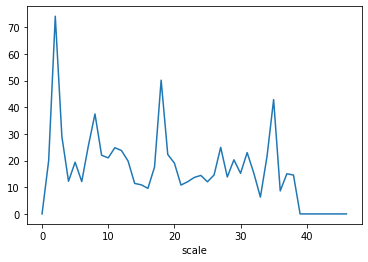

In [177]:
df_all['select_plot'] = df_all['select_rate1'].fillna(1).clip(0,None)
df_all[df_all['select_lastactive38']<1000].groupby('scale')['select_plot'].sum().plot()

In [178]:
# Use Census
# df_all = df_all.reset_index()
# df_all = df_all.set_index('cfips')

# df_all[df_census.columns] = df_census

# df_all = df_all.reset_index()
# df_all = df_all.set_index('row_id')

## Create features using model

In [201]:
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]

In [215]:
output_features = ['cfips', 'county', 'state', 'microbusiness_density', 'active', 'year','month', 'scale', 
                                 'mbd_pred', 'y_base', 'y_pred', 'smape']

def regularize(x):
    if x >= 1:
        if x * 0.999 >= 1:
            x *= 0.999
        else:
            x = 1
    else:
        if x * 1.001 <= 1:
            x *= 1.001
        else:
            x = 1
    return x


def get_trend_dict(valid_time, pred_m = 1, n=3, thre=2, active_thre=25000):
    target=mbd
    df_target_lag = df_all.loc[(df_all['scale'] >= valid_time - pred_m - n)&(df_all['scale']<=valid_time-pred_m), ['cfips','scale','active',target]].copy()
    for i in range(1, n+1):
        df_target_lag[f'lag_{i}'] = df_target_lag[target].shift(i)

    for i in range(1, n+1):
        if i==1:
            df_target_lag[f'rate{i}'] = df_target_lag[target] / df_target_lag[f'lag_{i}']
        else:
            df_target_lag[f'rate{i}'] = df_target_lag[f'lag_{i-1}'] / df_target_lag[f'lag_{i}']        

    df_target_lag['up_cnt'] = 0
    df_target_lag['down_cnt'] = 0
    df_target_lag['mean'] = 0
    for i in range(1, n+1):
        df_target_lag['up_cnt'] += (df_target_lag[f'rate{i}'] > 1)*1
        df_target_lag['down_cnt'] += (df_target_lag[f'rate{i}']<1)*1
        df_target_lag['mean'] += df_target_lag[f'rate{i}']
    df_target_lag['mean'] /= n

    df_target_lag['trend'] = df_target_lag[['up_cnt', 'mean']].apply(lambda x: x[1] if x[0] >= thre and x[1]>1 else np.nan, axis=1)
    df_target_lag['trend'] = df_target_lag[['down_cnt', 'mean', 'trend']].apply(lambda x: x[1] if x[0] >= thre and x[1]<1 else x[2], axis=1)
    idx = (df_target_lag['scale']==valid_time-pred_m)&(df_target_lag['active']>=active_thre)&(~df_target_lag['trend'].isna())
    df_trend = df_target_lag[idx].copy()
    #　df_trend['trend'] = df_trend['trend'].apply(regularize)
    df_trend['trend'] = df_trend['trend'].clip(0.995, 1.005)
    trend_dict = df_trend[['cfips', 'trend']].set_index('cfips').to_dict()['trend']
    
    return trend_dict


def create_features(pred_m, train_times, USE_LAG = USE_LAG):
    drop_features = ['microbusiness_density', 'active', 'scale']
    features = list(filter(lambda x: (not x.startswith('select_') and (x not in drop_features)),  df_all.columns.to_list()))
    
    # Select appropriate lastactive and lastmbd features.
    features.append(f'select_lastactive{train_times}')
    features.append(f'select_lastmbd{train_times}')
    features += list(filter(lambda x: (x.startswith(f'select_rate{pred_m}_')), df_all.columns.to_list()))
    
    # Select appropriate target and lag features.
    for i in range(pred_m, pred_m + USE_LAG):
        features.append(f'select_active_lag{i}')
        features.append(f'select_mbd_lag{i}')
    
    return features


def run_fit_predict(valid_time, pred_m, act_thre=2, ensemble=False):
    
    train_times = valid_time - pred_m
    
    print('valid_times: ', valid_time)
    print('pred_m: ', pred_m)
    print('train_times: ', train_times)

    target = f'select_rate{pred_m}'
    features = create_features(pred_m, train_times, USE_LAG)
    
    # Extract Valid and Train data.
    if USE_OLD_LOG:
        train_indices = (df_all['scale']<=train_times) & (df_all['scale']>=pred_m) & (df_all[f'select_lastactive{train_times}']>=act_thre)
    else:
        train_indices = (df_all['scale']<=train_times) & (df_all['scale']>=pred_m+USE_LAG) & (df_all[f'select_lastactive{train_times}']>=act_thre)
    
    X_train = df_all.loc[train_indices, features]
    y_train = df_all.loc[train_indices, target]

    df_valid =  df_all.loc[df_all['scale']==valid_time].copy()
    valid_indices = (df_valid[f'select_lastactive{train_times}']>=act_thre) & (~df_valid['cfips'].isin(blacklistcfips))  & (~df_valid['state'].isin(blacklist))
    X_valid = df_valid.loc[valid_indices, features]
    y_valid = df_valid.loc[valid_indices, target]
    
    # Create Model and predict.
    if ensemble:
        model = models.get_ensemble()
    else:
        model = models.get_lgbm()
    model.fit(X_train, y_train.clip(-0.0044, 0.0046))
    y_pred = model.predict(X_valid)
    
    # Use Model result.
    df_valid['y_pred'] = 1
    df_valid.loc[valid_indices, 'y_pred'] = y_pred
    
   # Convert y_pred to microbusiness_density prediction and create output dataset.
    base_indices = (df_all['scale']==train_times)
    base_y = df_all.loc[base_indices, ['cfips', 'microbusiness_density']]
    base_dict = base_y.set_index('cfips').to_dict()
    df_valid['y_base'] = df_valid['cfips'].map(base_dict['microbusiness_density'])
    df_valid['mbd_pred'] = df_valid['y_base'] * (df_valid['y_pred']+1)
    
    # Use Last Value.
    lastvalue_indices = ~(valid_indices)
    df_valid.loc[lastvalue_indices, 'mbd_pred'] = df_valid.loc[lastvalue_indices, f'select_lastmbd{train_times}']
    df_valid.loc[lastvalue_indices, 'y_pred'] = df_valid.loc[lastvalue_indices, f'select_rate{pred_m}_lag{pred_m}']
    
    # USE Trend.
    if USE_TREND and pred_m == 1:
        trend_dict = get_trend_dict(valid_time, pred_m, 3, 3, 25000)
        print('# of cfips that have trend :', len(trend_dict))
        for cfip in trend_dict:
            df_valid.loc[df_valid['cfips']==cfip, 'mbd_pred'] = df_valid.loc[df_valid['cfips']==cfip, 'y_base'] * trend_dict[cfip]
            df_valid.loc[df_valid['cfips']==cfip, 'y_pred'] = (trend_dict[cfip] - 1)
    
    df_valid['smape'] = utils.smape_arr(df_valid['microbusiness_density'], df_valid['mbd_pred'])
    df_output = df_valid[output_features]
    
    return df_output


def run_validation_for_pred_m(validation_times, pred_ms, ensemble=False):
    
    df_output = pd.DataFrame(columns=output_features)
    for validation_time, pred_m in zip(validation_times, pred_ms):
        df = run_fit_predict(validation_time, pred_m, ensemble=ensemble)
        df_output = pd.concat([df, df_output])

    return df_output.reset_index().rename(columns={'index': 'row_id'}).set_index('row_id')

## Run validation

In [216]:
def run_validation(max_month=38, m_len=5,  pred_ms = [1,2,3,4], ensemble=False):
    
        validation_times = [max_month - i for i in range(m_len)]
        
        output_dic = dict()
        for pred_m in pred_ms:
            pred_m_len = [pred_m] * m_len
            df_output = run_validation_for_pred_m(validation_times, pred_m_len, ensemble=ensemble)
            output_dic[pred_m] = df_output
        
        return output_dic

In [217]:
def export_scores_summary(output_dic, pred_ms = [1,2,3,4], filename='validation_score'):
    output_array = np.zeros((4, 2))
    for pred_m in pred_ms:
        df = output_dic[pred_m]
        output_array[pred_m-1] = df.groupby('scale')['smape'].mean().describe()[['mean', 'std']].to_numpy()

    df = pd.DataFrame(output_array, columns=['mean', 'std'], index=[1,2,3,4])
    df.to_csv(f'../output/{filename}.csv')

In [218]:
# output_dic = run_validation(38, 5)
# export_scores_summary(output_dic, filename=f'my002')

## Create submission

In [219]:
def create_submission(filename=''):
    df_pred = run_validation_for_pred_m([39], [1], ensemble=True)
    #df_pred = run_validation_for_pred_m([39,40,41,42], [1,2,3,4, ensemble=True)
    
    df_merged = pd.merge(df_subm, df_pred['mbd_pred'], how='left', on='row_id')
    df_merged.loc[~df_merged['mbd_pred'].isna(), 'microbusiness_density'] = df_merged['mbd_pred']
    df_submission = df_merged['microbusiness_density']
    
    if filename:
        df_submission.to_csv(f'../submission/{filename}.csv')
        print(f'saved {filename}')
        
    return df_pred, df_merged, df_submission

In [220]:
df_pred, df_merged, submission = create_submission(filename='sub_my003_ensemble')

valid_times:  39
pred_m:  1
train_times:  38
[LightGBM] [Warning] lambda_l1 is set=1.8386216853616875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8386216853616875
[LightGBM] [Warning] lambda_l2 is set=7.557660410418351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.557660410418351
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] num_iterations is set=200, n_iter=200 will be ignored. Current value: num_iterations=200
saved sub_my003_ensemble
